In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from icecream import ic

## Gibbs sampler

We will first code a Gibbs Sampler for the model where $y=(y_1,\dots,y_n)$ are independent $\mathcal{N}(\mu,
\tau^{-1})$ random variables with both $\mu$ and $\tau$ unknown.

We will assign the $\mathcal{N}(0,\omega^{-1})$ prior on $\mu$ and the $Gamma(\alpha,\beta)$ prior on $\tau$.

### Activity 1
In the Gibbs sampling procedure, there will be two full conditional distributions from which we will want to sample, namely $p(\mu \mid y, \tau)$ and $p(\tau \mid y, \mu)$. Initially, prove

$$
\mu |y,\tau \sim \mathcal{N}\left(\frac{\tau}{n\tau + \omega}\sum y_{i},\frac{1}{n\tau + \omega}\right)
$$
and
$$
\tau|y,\mu \sim Gamma \left(\alpha + \frac{n}{2}, \beta+\frac{1}{2}\sum (y_{i}-\mu)^{2}\right)
$$
You can create a Markdown cell like the one below and write your proof there.

We have that 

$$
p(\mu, y,\tau) \propto \prod_{i=1}^np(y_i\mid \mu, \tau)p(\mu)p(\tau)
$$
$$
= \prod_{i=1}^n\mathcal{N}(y_i\mid\mu,\tau^{-1})\mathcal{N}(0,\omega^{-1})\text{Gamma}(\alpha,\beta)
$$
$$
\propto \left(\sqrt{\frac{\tau}{2\pi}}\right)^nexp\left(-\frac{\tau}{2}\sum_{i=1}^n\left(y_i-\mu\right)^2\right)exp\left(-\frac{\omega}{2}\mu^2\right)\cdot\tau^{\alpha-1}exp(-\tau\beta)
$$
Considering the conditional probability on $\mu$, we disregard constants that do not depend on $\mu$
$$
\Rightarrow exp\left(-\frac{1}{2}\left(\tau\sum_{i=1}^n(y_i-\mu)^2+\omega\mu^2\right)\right)
$$
$$
= exp\left(-\frac{1}{2}\left( \mu^2(n\tau+\omega) - 2\tau\mu\sum_{i=1}^ny_i + \tau\sum_{i=1}^ny_i^2\right) \right)
$$
$$
= exp\left(-\frac{n\tau+\omega}{2}\left(\mu - \frac{\tau}{n\tau+\omega}\sum_{i=1}^ny_i\right)^2 + \text{ const w.r.t. } \mu\right)
$$
$$
\Rightarrow \mu \mid y,\tau \sim \mathcal{N}\left(\frac{\tau}{n\tau+\omega}\sum_{i=1}^ny_i,\frac{1}{n\tau+\omega}\right)
$$

Again we have that
$$
p(\mu, y,\tau) \propto \left(\sqrt{\frac{\tau}{2\pi}}\right)^nexp\left(-\frac{\tau}{2}\sum_{i=1}^n\left(y_i-\mu\right)^2\right)exp\left(-\frac{\omega}{2}\mu^2\right)\cdot\tau^{\alpha-1}exp(-\tau\beta)
$$
Considering the conditional probability on $\tau$, we disregard constants that do not depend on $\tau$
$$
\Rightarrow \tau^{\alpha+\frac{n}{2}-1}exp\left(-\tau\left(\frac{1}{2}\sum_{i=1}^n(y_i-\mu)^2+\beta\right)\right)
$$
$$
\Rightarrow \tau \mid y,\mu \sim \text{Gamma}\left( \alpha+\frac{n}{2},\beta+\frac{1}{2}\sum_{i=1}^n(y_i-\mu)^2 \right)
$$

In [20]:
#Simulated data to check the Gibbs sampler
n = 100 #sample size
sigma_true = 2
sigma2_true = sigma_true**2
mu_true = 5
np.random.seed(4)
y = mu_true + np.random.randn(n)*sigma_true
ybar = np.mean(y)
S2 = np.sum((y-ybar)**2)

print('sample mean:',ybar)
print('sample variance:',S2/(n-1))

sample mean: 5.070547155947767
sample variance: 3.8244883511126635


Implement the Gibbs sampler in the following cell and check posterior traceplots of mean and variance and compare them with true values.

In [21]:
def sample_mu(tau, y, w, n):
    mean = tau * np.sum(y) / (n*tau+w) 
    var = 1/(n*tau+w)
    mu = np.random.normal(mean, np.sqrt(var))
    return mu

def sample_tau(alpha, beta, mu, y, n):
    shape = alpha + n/2
    scale = beta + np.sum((y-mu)**2)/2
    tau = np.random.gamma(shape, 1/scale)
    return tau

def gibbs_sampling(mu0, tau0, alpha, beta, w, y, n):
    
    mu = [mu0]
    tau = [tau0]
    
    for i in range(n-1):
        
        mu.append(sample_mu(tau[i], y, w, n))
        tau.append(sample_tau(alpha, beta, mu[i+1], y, n))

    return mu, tau

alpha = 1
beta = 1
w = 1
mu0 = 0
tau0 = 0
mu, tau = gibbs_sampling(mu0, tau0, alpha, beta, w, y, n)
mean = np.mean(mu)
var = np.sum((y-mean)**2)/(n-1)
ic(mean, var)

ic| mean: 4.7994258441989635, var: 3.898737609379725


(4.7994258441989635, 3.898737609379725)

### Activity 2
Repeat for the model below

$$
y_i\sim \text{Poisson}(\mu), \;\;i=1,...,N,
$$
with priors 
$$
\mu \sim \text{Gamma}(2,\beta),\;\;
\beta \sim \text{Exponential}(1)
$$


$$
\mu| y,\beta \;\sim\;\text{Gamma}(2 + \sum_i y_i,n+\beta)
$$
$$
\beta|y,\mu\;\sim \;\text{Gamma}(3,1+\mu)
$$


$$
p(\mu, y,\beta) \propto \prod_{i=1}^np(y_i\mid \mu, \beta)p(\mu)p(\beta)
$$
$$
= \prod_{i=1}^n\text{Poisson}(y_i)\text{Gamma}(2,\beta)\text{Exponential}(1)
$$
$$
\propto \left( \prod_{i=1}^n\frac{\mu^{y_i}}{y_i!} exp\left(-\mu\right)\right) \cdot\beta^2\mu exp(-\mu\beta) exp(-\beta)
$$
Considering the conditional probability on $\mu$, we disregard constants that do not depend on $\mu$
$$
\Rightarrow \frac{\mu^{1+\sum_{i=1}^ny_i}\beta^2}{\prod_{i=1}^ny_i!} exp\left(-\mu(n+\beta)\right)
$$
$$
\Rightarrow \mu\mid y,\beta \;\sim \text{Gamma}\left(2 + \sum_{i=1}^n y_i,n+\beta\right)
$$
Again we have that 
$$
p(\mu, y,\beta) \propto \left( \prod_{i=1}^n\frac{\mu^{y_i}}{y_i!} exp\left(-\mu\right)\right) \cdot\beta^2\mu exp(-\mu\beta) exp(-\beta)
$$
Considering the conditional probability on $\beta$, we disregard constants that do not depend on $\beta$
$$
\Rightarrow \frac{\mu^{1+\sum_{i=1}^ny_i}\beta^2}{\prod_{i=1}^ny_i!} exp(-\beta(1+\mu))
$$
$$
\Rightarrow \beta\mid y,\mu\;\sim  \text{Gamma}(3,1+\mu)
$$

In [22]:
def sample_mu(beta, y, n):
    shape = 2 + np.sum(y)
    scale = n + beta 
    mu = np.random.gamma(shape, 1/scale)
    return mu

def sample_beta(mu):
    shape = 3
    scale = 1 + mu
    beta = np.random.gamma(shape, 1/scale)
    return beta

def gibbs_sampling(mu0, beta0, y, n):
    
    mu = [mu0]
    beta = [beta0]
    
    for i in range(n-1):
        
        mu.append(sample_mu(beta[i], y, n))
        beta.append(sample_beta(mu[i+1]))

    return mu, beta

n = 100
mu_true = 5
np.random.seed(4)
y = np.random.poisson(mu_true, n)
beta0 = np.random.exponential(1)
mu0 = np.random.gamma(2, beta0)

mu, beta = gibbs_sampling(mu0, beta0, y, n)
mean = np.mean(mu)
var = np.sum((y-mean)**2)/(n-1)
ic(mean, var)

ic| mean: 5.188201035521818, var: 5.709708256708974


(5.188201035521818, 5.709708256708974)

## Mean Field approximation 

We will first simulate $100$ independent observations from the model 

$$
y\sim N(\mu, \tau^{-1})
$$

with $\mu=5$ and $\tau^{-1}=0.5$.

Treat $\mu$ and $\tau^{-1}$ as unknown and  use the mean field approximation algorithm presented in the lecture to estimate them.

#### Simulate Data

In [125]:
#Set parameters and simulate data
n = 1000
mu = 5
tau = 2
std = np.sqrt(1/tau)
y = mu + std*np.random.randn(n)

#Set prior hyperparameters
mu0 = 0
lam0 = 1 #unit information prior
a0 = 0.001
b0 = 0.001

# get sufficient stats
Sy = np.sum(y)
Sy2 = np.sum(y**2)
m02 = mu0**2

### Activity 3
Implement the algorithm

In [126]:
q_mu = []
q_tau = []

mu_N = mu0
tau_N = lam0
a_N = a0
b_N = b0
diff = np.inf

n_its = 1000
tol = 1e-10
i = 0

while (i < n_its) and (diff > tol):
    
    thetas = np.array([mu_N, tau_N, a_N, b_N])

    Emu = Sy/n
    Etau = (n-1) / (Sy2 - 2*Emu*Sy + n*Emu**2)
    Etau = a_N/b_N
    Emu2 = Emu**2 + 1/(n*Etau)
    
    mu_N = (lam0*mu0+Sy) / (lam0+n)
    tau_N = (lam0+n)*Etau
    q_mu.append(np.random.normal(mu_N, np.sqrt(1/tau_N)))

    a_N = a0 + (n+1)/2
    b_N = b0 + (Sy2 - 2*Emu*Sy + n*Emu2)/2 + lam0*(Emu2 - 2*Emu*mu0 + m02)/2
    q_tau.append(np.random.gamma(a_N, 1/b_N))

    thetas_new = np.array([mu_N, tau_N, a_N, b_N])
    dThetas = (thetas - thetas_new)**2
    diff = np.max(dThetas)
    i += 1

mu_mean = np.mean(q_mu)
tau_mean = np.mean(q_tau)
ic(i, mu_mean, tau_mean)

ic| i: 5, mu_mean: 4.988247925014025, tau_mean: 1.9181489406270251


(5, 4.988247925014025, 1.9181489406270251)

Let $y=(y_1, \dots, y_n)$ be independent Poisson($\lambda$) observations. Assume that $\lambda$ follows the Gamma($2,\beta$) distribution, where $\beta$ follows the Exponential($1$) distribution. The aim is to draw inference from the posterior $\pi(\theta|y)$, where $\theta=(\lambda, \beta)$. 

In [24]:
#Set parameters and simulate data
n = 100
np.random.seed(1)
beta_true = np.random.exponential(1,1)
lambda_true  = np.random.gamma(2,1/beta_true,1)
print('beta value: ',beta_true,' lambda value: ',lambda_true)
y = np.random.poisson(lambda_true,n)

# get sufficient stats
sy = np.sum(y)
print('ybar: ',sy/n)

beta value:  [0.53960584]  lambda value:  [1.53955169]
ybar:  1.41


The variational Bayes algorithm **approximates** $\pi(\theta|y)$ using the mean field approximation 

$$
q(\theta|y, \phi)=q(\lambda|y, \phi)q(\beta|y, \phi)
$$

It can be shown that such an algorithm may consist of the following steps

 1. Initialise at $q(\lambda)$ to be the Gamma($a_{\lambda},b_{\lambda}$) and $q(\beta)$ to be the Gamma($a_{\beta},b_{\beta}$) distribution, setting $$a_{\lambda}=2+\sum_iy_i,\;\; b_{\lambda}=b_{\lambda}^0,\;\;\;a_{\beta}=3,\;\text{ and }\;\;b_{\beta}=b_{\beta}^0. $$
 2. Iteratively update $b_{\lambda}$ and $b_{\beta}$ until the parameters or the ELBO converge. At iteration $i$ will have:
 
    a. Set $$b_{\lambda}^{i}=n+\mathbb{E}_{q(\beta)}[\beta]=n+3/b_{\beta}^{i-1}$$
    
    b. Set $$b_{\beta}^{i}=1+\mathbb{E}_{q(\lambda)}[\lambda]=1+(2+\sum_iy_i)/b_{\lambda}^{i}$$

### Activity 4
Code the above algorithm and fit it to the simulated data. Check your answers in terms of the lambda estimates.

Put your code below

In [25]:
a_lam = 2 + sy
a_beta = 3
b_lam0 = 1
b_beta0 = 1

b_lam = b_lam0
b_beta = b_beta0

lam = np.random.gamma(a_lam, 1/b_lam0)
beta = np.random.gamma(a_beta, 1/b_beta0)

q_lam = [lam]
q_beta = [beta]

for i in range(10000):
    b_lam_new = n + 3/b_beta
    b_beta_new = 1 + ((2 + sy) / b_lam)

    b_lam = b_lam_new
    b_beta = b_beta_new

    lam = np.random.gamma(a_lam, 1/b_lam)
    beta = np.random.gamma(a_beta, 1/b_beta)   

    q_lam.append(lam)
    q_beta.append(beta)

ic(np.mean(q_beta), np.mean(q_lam))

ic| np.mean(q_beta): 1.2503222499673918
    np.mean(q_lam): 1.4243739944686546


(1.2503222499673918, 1.4243739944686546)

## Image denosing with Gibbs sampling

Text(0.5, 1.0, 'True binary image')

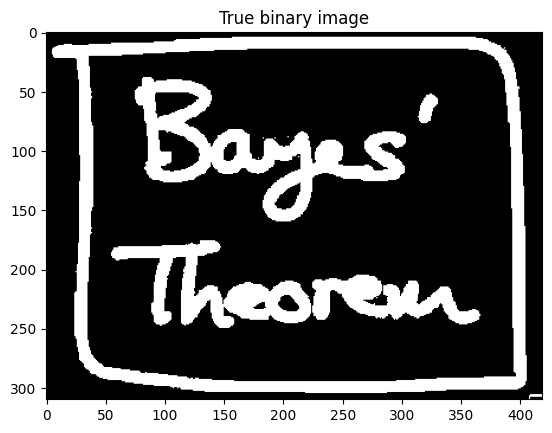

In [26]:
#load image data
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

plt.figure()
plt.imshow(clean_img,cmap='Greys')
plt.title("True binary image")

310 419


Text(0.5, 1.0, 'observed noisy image')

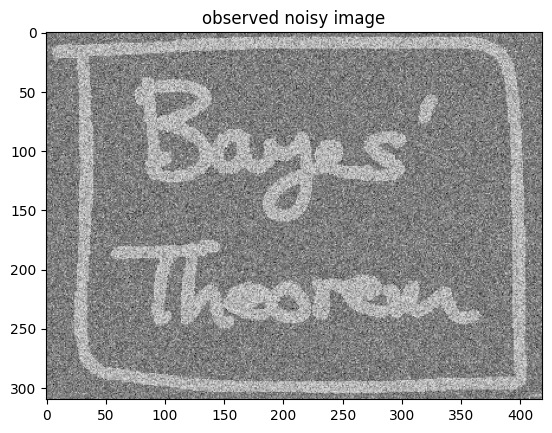

In [27]:
height,width = clean_img.shape
print(height,width)
sigma  = 1  #noise level
noisy_img = clean_img + sigma*np.random.randn(height, width)
plt.figure()
plt.imshow(noisy_img, cmap='Greys')
plt.title("observed noisy image")

### Activity 5
Implement Gibbs sampler for Ising model presented in the lecture to denoise the image. Comapre denoised image with the original image.


Initialization: $\{x_i : i = 1, \ldots, M\}$ to some initial values $\{x^{(1)}_i\}$, e.g., $x^{(1)}_i = +1$ and $x^{(1)}_i = -1$ with probability $\frac{1}{2}$.

For $\tau = 1, \ldots, T$ repeat:


1. Sample $x^{(\tau+1)}_1 \sim p(x_1 | x^{(\tau)}_2, x^{(\tau)}_3, \ldots, x^{(\tau)}_M, y_1)$
2. Sample $x^{(\tau+1)}_2 \sim p(x_2 | x^{(\tau+1)}_1, x^{(\tau)}_3, \ldots, x^{(\tau)}_M, y_2)$
   
   $\vdots$

. Sample $x^{(\tau+1)}_M \sim p(x_M | x^{(\tau+1)}_1, x^{(\tau+1)}_2, \ldots, x^{(\tau+1)}_{M-1}, y_M)$


$$
p(x_i = +1 | x_{\setminus i}, y) = \frac{\exp\left(\beta \sum_{j \in N(i)} x_j + \eta y_i\right)}{\exp\left(\beta \sum_{j \in N(i)} x_j + \eta y_i\right) + \exp\left(-\beta \sum_{j \in N(i)} x_j - \eta y_i\right)} = \sigma\left(2\left(\eta y_i + \beta \sum_{j \in N(i)} x_j\right)\right)
$$


In [28]:
def ising_model_gibbs(y, G, beta, eta, n_its):
    x = np.copy(y)
    N = np.size(x,0)
    M = np.size(x,1)

    for n in range(n_its):
        for i in range(N):
            for j in range(M):
                
                if np.random.rand() < 0.7:
                    E = 0
                    
                    if i > 0:
                        E += x[i-1,j]
                    if i < N-1:
                        E += x[i+1,j]
                    if j > 0:
                        E += x[i,j-1]
                    if j < M-1:
                        E += x[i,j+1]

                    E_pos = 2*(beta*E + eta*y[i,j])

                    if np.random.rand() < 1/(1+np.exp(-E_pos)):
                        x[i,j] = 1
                    else:
                        x[i,j] = -1

        NMSE = np.sum((x - G)**2) / np.sum(G**2)
        print('Iteration:',n+1, end='\r')
    
    return x, NMSE

0.02676110555085072


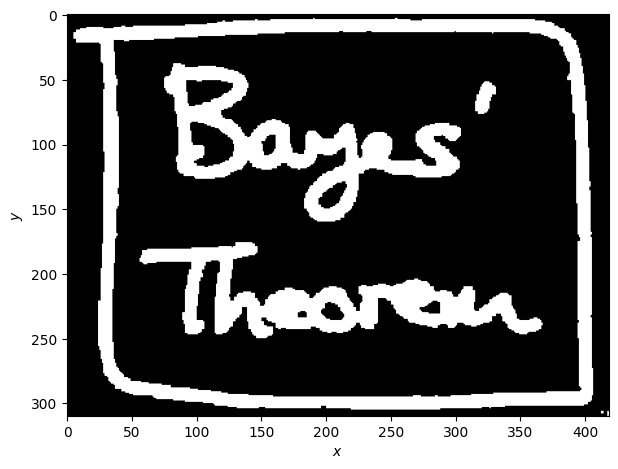

In [105]:
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigma  = 1
noisy_img = clean_img + sigma*np.random.randn(height, width)

beta = 2
eta = 1
n_its = 15

x, NMSE = ising_model_gibbs(noisy_img, clean_img, beta, eta, n_its)
print(NMSE)

fig = plt.figure()
plt.xlabel('$x$')
plt.ylabel('$y$')
fig.tight_layout()
plt.imshow(x, cmap='Greys')
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\denoised_image_1.png'
fig.savefig(path, dpi=300)

Try different noise levels and plot the normalized mean squared error (NMSE) vs noise level.


[0.011794595426899684, 0.02753098775887289, 0.14119639695126646, 0.4660558934483024, 0.8274078066055893, 1.149095388405574, 1.3324813303564556, 1.4798059896835785, 1.5714527677265377, 1.6454230502733083, 1.71110940026176]


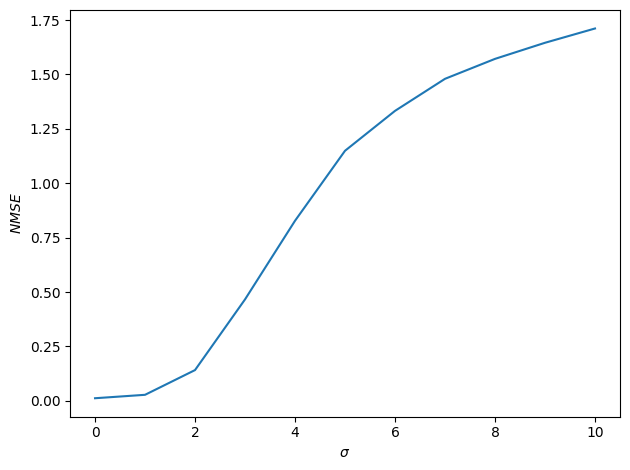

In [29]:
# NMSE vs sigma

data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigmas = np.linspace(0,10,11)
NMSEs_sigma_gibbs = []

beta = 2
eta = 1
n_its = 15

for sigma in sigmas:
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    x, NMSE = ising_model_gibbs(noisy_img, clean_img, beta, eta, n_its)
    NMSEs_sigma_gibbs.append(NMSE)

print(NMSEs_sigma_gibbs)

fig = plt.figure()
plt.plot(sigmas, NMSEs_sigma_gibbs)
plt.xlabel(r'$\sigma$')
plt.ylabel('$NMSE$')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(sigma)_1.png'
# fig.savefig(path, dpi=300)
plt.show()

Try different parameters in the energy function, e.g., $ \beta, \eta$, and  plot the following figures.
1. NMSE vs $ \beta$
2. NMSE vs $ \eta$

[0.8986681037801216, 0.03248902917853568, 0.02636076680267919, 0.02706905843405959, 0.03051813072599892, 0.02903995688659635, 0.027007467857417814, 0.030148587266148278, 0.028300869966895063, 0.03187312341211795, 0.030579721302640694]


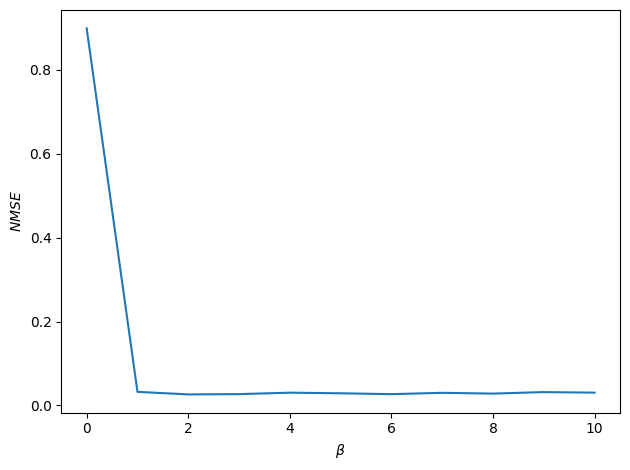

In [33]:
# NMSE vs beta

data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigma = 1
noisy_img = clean_img + sigma*np.random.randn(height, width)
NMSEs_beta_gibbs = []

betas = np.linspace(0,10,11)
eta = 1
n_its = 15

for beta in betas:
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    x, NMSE = ising_model_gibbs(noisy_img, clean_img, beta, eta, n_its)
    NMSEs_beta_gibbs.append(NMSE)

print(NMSEs_beta_gibbs)

fig = plt.figure()
plt.plot(betas, NMSEs_beta_gibbs)
plt.xlabel(r'$\beta$')
plt.ylabel('$NMSE$')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(beta)_1.png'
# fig.savefig(path, dpi=300)
plt.show()

[0.09423358226191393, 0.02706905843405959, 0.02180306413118793, 0.028578027561783046, 0.03720070829163138, 0.06119023789360228, 0.09441835399183925, 0.12857032873970284, 0.1617984448379398, 0.19699745938871352, 0.2179998460235584]


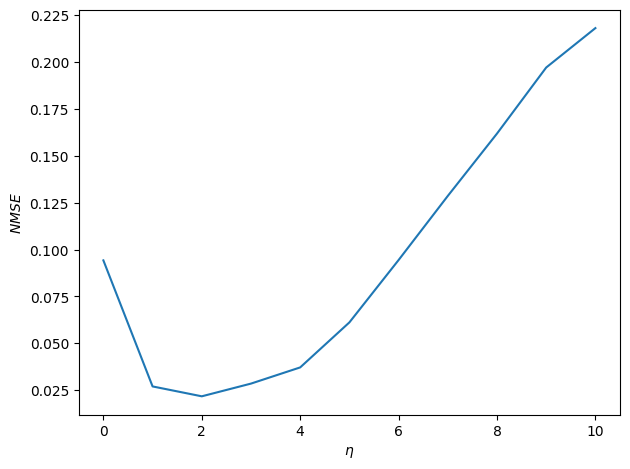

In [34]:
# NMSE vs eta

data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigma = 1
noisy_img = clean_img + sigma*np.random.randn(height, width)
NMSEs_eta_gibbs = []

beta = 2
etas = np.linspace(0,10,11)
n_its = 15

for eta in etas:
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    x, NMSE = ising_model_gibbs(noisy_img, clean_img, beta, eta, n_its)
    NMSEs_eta_gibbs.append(NMSE)

print(NMSEs_eta_gibbs)

fig = plt.figure()
plt.plot(etas, NMSEs_eta_gibbs)
plt.xlabel(r'$\eta$')
plt.ylabel('$NMSE$')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(eta)_1.png'
# fig.savefig(path, dpi=300)
plt.show()

## Image denosing with Mean-field approximation

Now, we try to apply mean-field approximation to denoise the image.
The posterior for Ising model has the following form
$$P(x\mid y) = \frac{1}{Z}exp(-E(x))$$
where
$$E(x) = E_{0}(x) - \sum_{i}L_{i}(x_{i}) \;\;\;\;\;\; E_{0}(x) = - \beta\sum_{i,j}x_{i}x_{j},\;\;\;  L_{i}(x_{i}) = \eta\sum_{i}x_{i}y_{i}$$
In mean-field approximation, we try to approximate this posterior by a fully factored approximation
$$q(x) = \prod_{i}q(x_{i}, \mu_{i})$$
where $\mu_{i}$ is the mean value of node $i$. To derive the update for the variational parameter $\mu_{i}$, we
first write out $log\tilde{p}(x) = -E(x)$, dropping terms that do not involve $x_{i}$:
$$log\tilde{p}(x) = \beta x_{i} \sum_{j}x_{j} + L_{i}(x_{i}) + const$$
This only depends on the states of the neighboring nodes. Now we take expectations of this wrt
$ \prod_{j\neq i}q(x_{i})$ to get
$$q(x_{i}) \propto exp(x_{i}\sum_{j}\beta \mu_{j} + L_{i}(x_{i})) $$
Thus we replace the states of the neighbors by their average values. Let
$$ m_{i} = \sum_{j} \beta \mu_{j} $$
be the mean field influence on node $i$. Also, let $L_{i}^{+}=L_{i}(1)$ and $L_{i}^{-}=L_{i}(-1)$. The
approximate marginal posterior is given by
$$q_{i}(x_{i}=1)=\frac{exp(m_{i}+L_{i}^{+})}{exp(m_{i}+L_{i}^{+})+exp(-m_{i}+L_{i}^{-})}=sigm(2a_{i}),\;\;\;\;\;\;a_{i}=m_{i}+0.5(L_{i}^{+}-L_{i}^{-})  $$
Similarly, we have $q_{i}(x_{i}=-1) = sigm(-2a_{i})$. From this we can compute the new mean for
site $i$:
$$\mu_{i} = \mathbb{E}_{q_{i}}[x_{i}] = tanh(a_{i})$$
Hence the update equation becomes
$$\mu_{i} = \mathbb{E}_{q_{i}}[x_{i}] =q_{i}(x_{i}=+1)(+1) + q_{i}(x_{i}=-1)(-1) = tanh(a_{i})$$
Hence the update equation becomes
$$\mu_{i} = tanh(\sum_{j} \beta \mu_{j}+0.5(L_{i}^{+}-L_{i}^{-}) )$$
We can turn the above equations in to a fixed point algorithm by writing
$$\mu_{i}^{t} = tanh(\sum_{j} \beta \mu_{j}^{t-1}+0.5(L_{i}^{+}-L_{i}^{-}) )$$
It is usually better to use damped updates of the form
$$\mu_{i}^{t} = (1-\lambda)\mu_{j}^{t-1} + \lambda tanh(\sum_{j} \beta \mu_{j}^{t-1}+0.5(L_{i}^{+}-L_{i}^{-}) ) ,\;\;\;\;\;\; 0<\lambda<1$$

### Activity 6
Write your code below to denoise the image using mean-field approximation and draw the same plots as image denoising using Gibbs sampling.

In [30]:
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

def ising_model_mean_field(y, G, beta, eta, n_its):
    x = np.copy(y)
    N = np.size(x,0)
    M = np.size(x,1)
    mu = np.copy(y)
    mu_new = np.copy(mu)
    lam = 0.5

    for n in range(n_its):
        for i in range(N):
            for j in range(M):

                mu_j = 0
                
                if i > 0:
                    mu_j += mu[i-1,j]
                if i < N-1:
                    mu_j += mu[i+1,j]
                if j > 0:
                    mu_j += mu[i,j-1]
                if j < M-1:
                    mu_j += mu[i,j+1]
                
                L_plus = 1*eta*y[i,j]
                L_minus = -1*eta*y[i,j]

                mu_new[i,j] = (1-lam)*mu[i,j] + lam*np.tanh(beta*mu_j + 0.5*(L_plus-L_minus))

        mu = np.copy(mu_new)

        NMSE = np.sum((mu - G)**2) / np.sum(G**2)
        print('Iteration:',n+1, end='\r')
    
    return mu, NMSE

NMSE: 0.016815430921287795


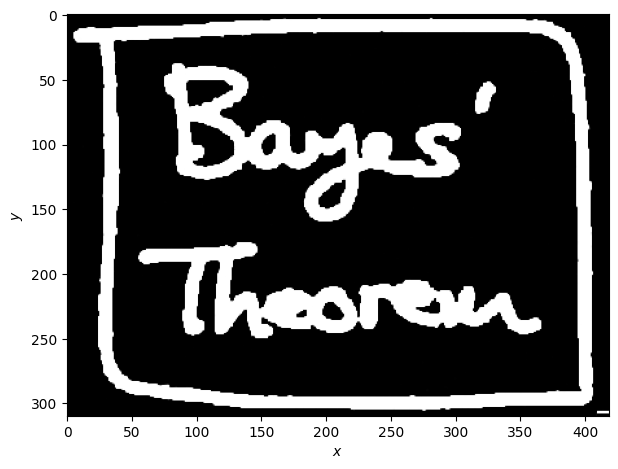

In [53]:
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigma = 1
noisy_img = clean_img + sigma*np.random.randn(height, width)

beta = 2
eta = 1
n_its = 10

mu, NMSE = ising_model_mean_field(noisy_img, clean_img, beta, eta, n_its)
print('NMSE:', NMSE)

fig = plt.figure()
plt.xlabel('$x$')
plt.ylabel('$y$')
fig.tight_layout()
plt.imshow(mu, cmap='Greys')
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\denoised_image_mf_1.png'
fig.savefig(path, dpi=300)

[0.004758214514430426, 0.016679589179618346, 0.13188658867553402, 0.4816743913002565, 0.84934476375732, 1.0694598580030663, 1.2780354345770542, 1.423116847665134, 1.520984986981139, 1.5945017498195477, 1.6405743967569086]


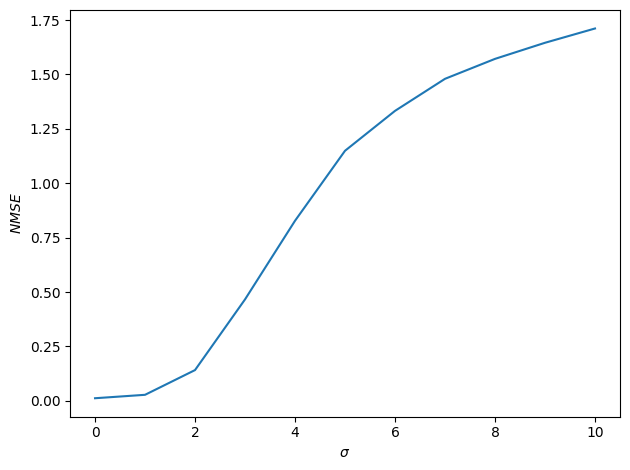

In [31]:
# NMSE vs sigma

data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigmas = np.linspace(0,10,11)
NMSEs_sigma_mf = []

beta = 2
eta = 1
n_its = 15

for sigma in sigmas:
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    x, NMSE = ising_model_mean_field(noisy_img, clean_img, beta, eta, n_its)
    NMSEs_sigma_mf.append(NMSE)

print(NMSEs_sigma_mf)

fig = plt.figure()
plt.plot(sigmas, NMSEs_sigma_gibbs)
plt.xlabel(r'$\sigma$')
plt.ylabel('$NMSE$')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(sigma)_mf_1.png'
# fig.savefig(path, dpi=300)
plt.show()

[0.45098215923307294, 0.016533089539426945, 0.01827352022069235, 0.017337254632899063, 0.017829165446977262, 0.019319208677905455, 0.020235311227568255, 0.022078140347296916, 0.021012080595362942, 0.021955284848719437, 0.02122684962152621]


ValueError: x and y must have same first dimension, but have shapes (1,) and (11,)

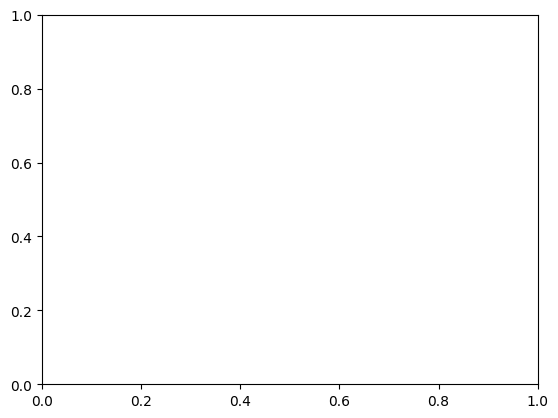

In [35]:
# NMSE vs beta

data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigma = 1
noisy_img = clean_img + sigma*np.random.randn(height, width)
NMSEs_beta_mf = []

betas = np.linspace(0,10,11)
eta = 1
n_its = 15

for beta in betas:
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    x, NMSE = ising_model_mean_field(noisy_img, clean_img, beta, eta, n_its)
    NMSEs_beta_mf.append(NMSE)

print(NMSEs_beta_mf)

fig = plt.figure()
plt.plot(betas, NMSEs_beta_mf)
plt.xlabel(r'$\beta$')
plt.ylabel('$NMSE$')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(beta)_mf_1.png'
# fig.savefig(path, dpi=300)
plt.show()

[0.02717512988320278, 0.018525539047532413, 0.01973479777709366, 0.023383111918169237, 0.03312119473091328, 0.057105626153262604, 0.08510227354440164, 0.11262392412279053, 0.1450553127390478, 0.17775310591169013, 0.20009089958745524]


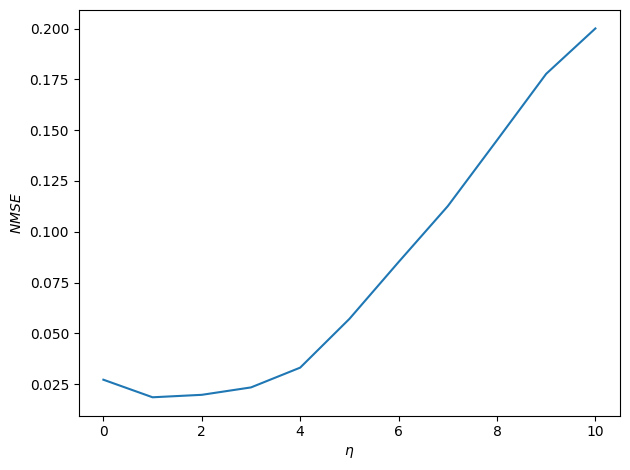

In [36]:
# NMSE vs eta

data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

height,width = clean_img.shape
sigma = 1
noisy_img = clean_img + sigma*np.random.randn(height, width)
NMSEs_eta_mf = []

beta = 2
etas = np.linspace(0,10,11)
n_its = 15

for eta in etas:
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    x, NMSE = ising_model_mean_field(noisy_img, clean_img, beta, eta, n_its)
    NMSEs_eta_mf.append(NMSE)

print(NMSEs_eta_mf)

fig = plt.figure()
plt.plot(etas, NMSEs_eta_mf)
plt.xlabel(r'$\eta$')
plt.ylabel('$NMSE$')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(eta)_mf_1.png'
# fig.savefig(path, dpi=300)
plt.show()

### Activity 7
Compare the NMSE of the denoising schemes that you have implemented here and the previous Python lab, e.g., ICM, Gibbs sampling, and mean-field approximation.

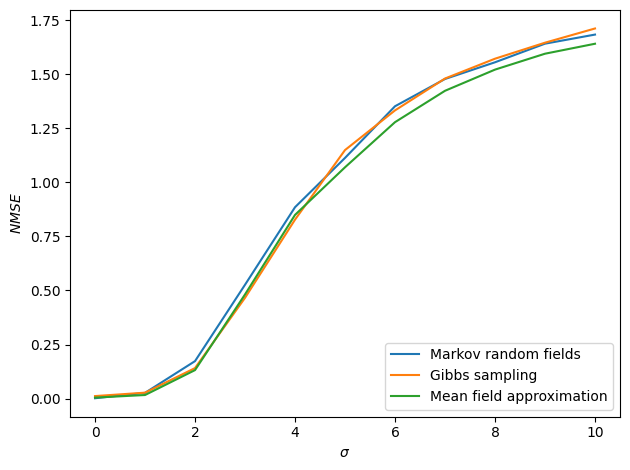

In [32]:
NMSEs_sigma_MRF = [0.0018169220109323274, 0.02666871968588806, 0.17337747324659328, 0.5264454538455616, 0.8848410193240435, 1.1128185387635692, 1.3516052044037263, 1.4776503195011164, 1.5548849026099008, 1.640865347601817, 1.6829317114481483]
NMSEs_sigma_gibbs = [0.011794595426899684, 0.02753098775887289, 0.14119639695126646, 0.4660558934483024, 0.8274078066055893, 1.149095388405574, 1.3324813303564556, 1.4798059896835785, 1.5714527677265377, 1.6454230502733083, 1.71110940026176]
NMSEs_sigma_mf = [0.004758214514430426, 0.016679589179618346, 0.13188658867553402, 0.4816743913002565, 0.84934476375732, 1.0694598580030663, 1.2780354345770542, 1.423116847665134, 1.520984986981139, 1.5945017498195477, 1.6405743967569086]

fig = plt.figure()
plt.plot(sigmas, NMSEs_sigma_MRF, label='Markov random fields')
plt.plot(sigmas, NMSEs_sigma_gibbs, label='Gibbs sampling')
plt.plot(sigmas, NMSEs_sigma_mf, label='Mean field approximation')
plt.xlabel(r'$\sigma$')
plt.ylabel('$NMSE$')
plt.legend(loc='lower right')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(sigma)_mrf_gibbs_mf_2.png'
fig.savefig(path, dpi=300)
plt.show()

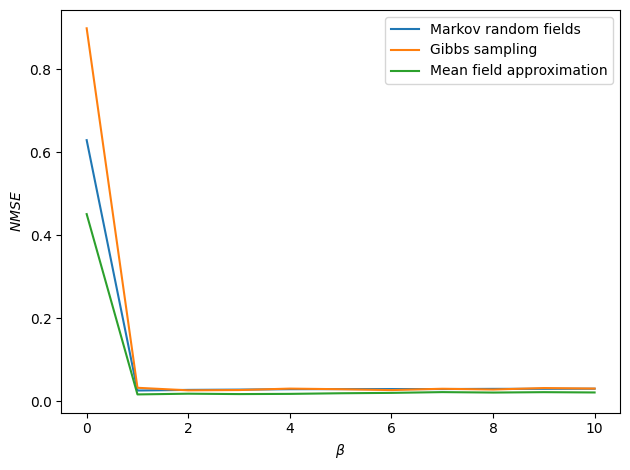

In [44]:
NMSEs_beta_MRF = [0.6292093309723612, 0.025929632766186775, 0.02743860189391023, 0.028116098236969745, 0.029101547463238123, 0.029317114481484333, 0.02944029563476788, 0.029471090923088767, 0.029902224959581183, 0.030056201401185617, 0.030271768419431827]
NMSEs_beta_gibbs = [0.8986681037801216, 0.03248902917853568, 0.02636076680267919, 0.02706905843405959, 0.03051813072599892, 0.02903995688659635, 0.027007467857417814, 0.030148587266148278, 0.028300869966895063, 0.03187312341211795, 0.030579721302640694]
NMSEs_beta_mf = [0.45098215923307294, 0.016533089539426945, 0.01827352022069235, 0.017337254632899063, 0.017829165446977262, 0.019319208677905455, 0.020235311227568255, 0.022078140347296916, 0.021012080595362942, 0.021955284848719437, 0.02122684962152621]


fig = plt.figure()
plt.plot(betas, NMSEs_beta_MRF, label='Markov random fields')
plt.plot(betas, NMSEs_beta_gibbs, label='Gibbs sampling')
plt.plot(betas, NMSEs_beta_mf, label='Mean field approximation')
plt.xlabel(r'$\beta$')
plt.ylabel('$NMSE$')
plt.legend(loc='upper right')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(beta)_mrf_gibbs_mf_2.png'
fig.savefig(path, dpi=300)
plt.show()

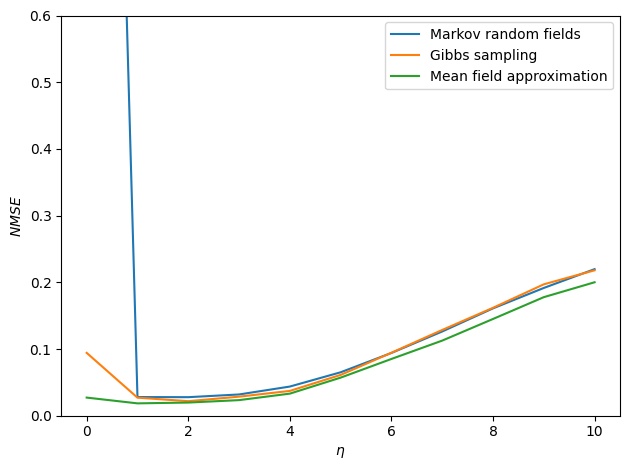

In [43]:
NMSEs_eta_MRF = [2.7256601739933792, 0.027992917083686196, 0.027808145353760874, 0.03187312341211795, 0.043729309415659404, 0.0651320347986758, 0.0940796058203095, 0.1262914774039572, 0.16096697205327584, 0.19154669335591654, 0.21975517745784895]
NMSEs_eta_gibbs = [0.09423358226191393, 0.02706905843405959, 0.02180306413118793, 0.028578027561783046, 0.03720070829163138, 0.06119023789360228, 0.09441835399183925, 0.12857032873970284, 0.1617984448379398, 0.19699745938871352, 0.2179998460235584]
NMSEs_eta_mf = [0.02717512988320278, 0.018525539047532413, 0.01973479777709366, 0.023383111918169237, 0.03312119473091328, 0.057105626153262604, 0.08510227354440164, 0.11262392412279053, 0.1450553127390478, 0.17775310591169013, 0.20009089958745524]

fig = plt.figure()
plt.plot(etas, NMSEs_eta_MRF, label='Markov random fields')
plt.plot(etas, NMSEs_eta_gibbs, label='Gibbs sampling')
plt.plot(etas, NMSEs_eta_mf, label='Mean field approximation')
plt.xlabel(r'$\eta$')
plt.ylabel('$NMSE$')
plt.ylim([0,0.6])
plt.legend(loc='upper right')
fig.tight_layout()
path = r'C:\Users\erikn\skola\SSY316-Advanced-Probabilistic-Machine-Learning\python-lab-4\report-images\NMSE(eta)_mrf_gibbs_mf_2.png'
fig.savefig(path, dpi=300)
plt.show()